In [ ]:
import wmfdata as wmf

In [ ]:


(
    wmf.spark.run("""
        SELECT
            month, 
            wikimedia_region,
            SUM(IF(
                activity_level IN ('5 to 99', '100 or more'),
                namespace_zero_distinct_editors,
                0
            )) AS active_editors
        FROM wmf.unique_editors_by_country_monthly uem
        LEFT JOIN canonical_data.countries cdc
        ON uem.country_code = cdc.iso_code
        WHERE 
            users_are_anonymous = False
            AND month > '2022-01'
            AND wikimedia_region IS NOT NULL
            AND wikimedia_region != ''
        GROUP BY 
            month,
            wikimedia_region
        ORDER BY 
            month,
            wikimedia_region
    """)
    .pivot(index='month', columns='wikimedia_region', values='active_editors')
    .to_csv('resources/data/regional_editor_metrics.csv')
)

Generating Regional Active Editors chart...


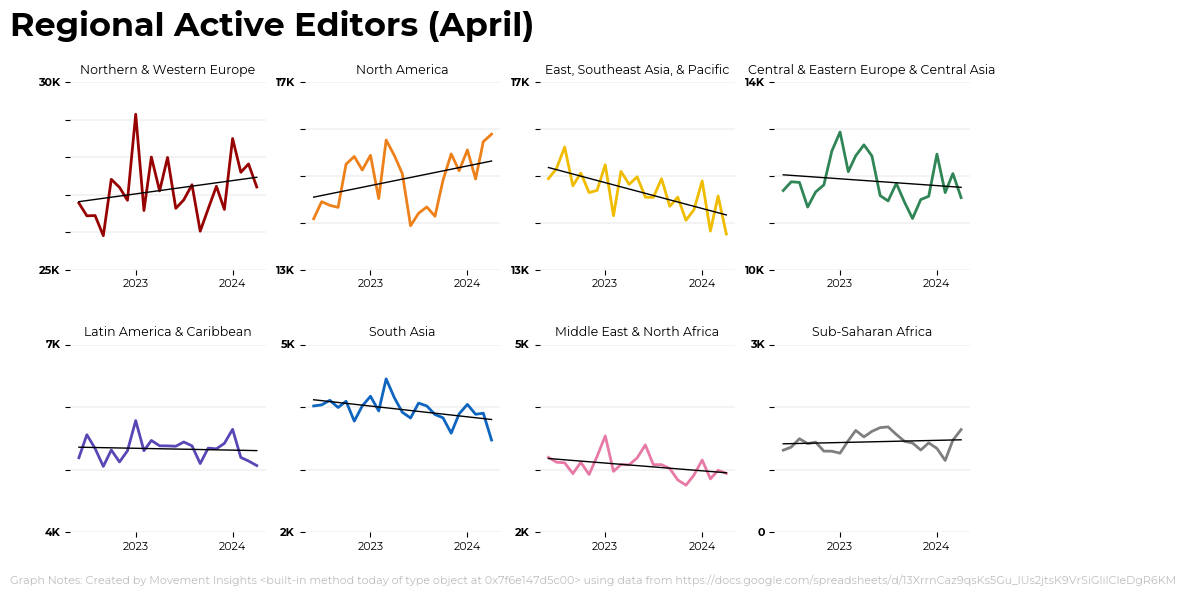

In [2]:
from wikicharts import Wikichart
import pandas as pd
from config import wmf_colors,  key_colors
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np

import warnings
from math import ceil, floor, log10
from data_utils import gen_keys, round_to_nearest

def main():
    print("Generating Regional Active Editors chart...")

    warnings.filterwarnings("ignore")

    #---PROMPT FOR INPUT---
    save_file_name_base = "Regional_Active_Editors"
    yoy_note = " "
    display_flag = True

    #---CLEAN DATA--
    df = pd.read_csv(
        'resources/data/regional_editor_metrics.csv',
        parse_dates=["month"],
        index_col="month"
    )
    start_date = "2018-05-01"
    end_date = datetime.today()
    col_order = df.iloc[-1].sort_values(ascending=False).index
    df = df[col_order]
    dfs = [df.reset_index()]
    
    #---MAKE CHARTS---
    max_charts_per_figure = 8
    fig_counter = 0
    keys = gen_keys(dfs, key_colors)
    total_num_charts = len(df.columns) - 1
    num_figures = ceil(total_num_charts / max_charts_per_figure)
    figures = [None] * num_figures

    for f in range(num_figures):
        fig_counter += 1
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f] = Wikichart(start_date, end_date, dfs[f])
        figures[f].init_plot(width=12, subplotsx=2, subplotsy=4, fignum=f)
        figures[f].plot_subplots_lines('month', keys[f], num_charts=charts_in_figure, subplot_title_size=9)
        figures[f].plot_multi_trendlines('month', keys[f], num_charts=charts_in_figure)

        # Set individual y-axis limits and labels for each subplot
        for i, ax in enumerate(figures[f].ax.flat):
            if i < charts_in_figure:
                region_label = keys[f].iloc[i]['labelname']
                region_data = dfs[f][region_label].dropna()
                ymin = max(0, round_to_nearest(region_data.min()) - 1000)  
                ymax = round_to_nearest(region_data.max()) + 1000  
                ax.set_ylim(ymin, ymax)

                y_ticks = np.arange(ymin, ymax + 1000, 1000)  # Adjust step as needed
                y_labels = [f'{int(tick/1000)}k' if tick != 0 else '0' for tick in y_ticks]
                ax.set_yticks(y_ticks)
                ax.set_yticklabels(y_labels)

        figures[f].format_subplots(title='Regional Active Editors',
                                   key=keys[f],
                                   data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
                                   num_charts=charts_in_figure,
                                   tickfontsize=8)
        figures[f].clean_ylabels_subplots(tickfontsize=8)
        save_file_name = save_file_name_base + "_" + str(f) + ".jpeg"
        figures[f].finalize_plot(save_file_name, display=False)
    
if __name__ == "__main__":
    main()